# Analyze Tags of Movies
## Can movies be described by their similarities in a latent space of tag ratings?

### ~13000 movies, and ~1000 tags
### How relevant is each tag to each movie? (0-1)


In [1]:
# Loading autotime for the notebook
%load_ext autotime

time: 357 µs (started: 2022-08-22 14:55:07 +00:00)


In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

time: 1.2 ms (started: 2022-08-22 14:55:07 +00:00)


In [3]:
# SparkSession
from pyspark.sql import SparkSession
from seaborn import heatmap

import pandas as pd

spark = SparkSession.builder.master("local") \
                            .appName("PCA_ML_Lib") \
                            .getOrCreate()

time: 5.54 s (started: 2022-08-22 14:55:07 +00:00)


In [4]:
df = pd.read_csv("s3a://sparkdemonstration/movielens-tag-relevance.csv", header="infer")
df = spark.createDataFrame(df)

time: 3min 31s (started: 2022-08-22 14:55:13 +00:00)


In [5]:
import random
colsToShow = ['title'] + [random.choice(df.columns) for i in range(4)]
df.select(*colsToShow).show()

+--------------------+-------------------+--------------------+--------------------+--------------------+
|               title|       storytelling|                 spy|             ominous|   fountain of youth|
+--------------------+-------------------+--------------------+--------------------+--------------------+
|    Toy Story (1995)|               0.76| 0.17049999999999998|             0.10925|             0.03025|
|      Jumanji (1995)|0.35550000000000004|             0.09125|             0.14025|0.044499999999999984|
|Grumpier Old Men ...|0.33325000000000005| 0.05825000000000001|              0.0695|0.028000000000000025|
|Waiting to Exhale...|              0.333| 0.05049999999999999|             0.03375|0.019000000000000017|
|Father of the Bri...|            0.29375| 0.05475000000000002|0.044999999999999984|             0.03275|
|         Heat (1995)|             0.7475|              0.0665|             0.10075|0.009000000000000008|
|      Sabrina (1995)|            0.38025|    

In [6]:
df.count()

13816

time: 5.24 s (started: 2022-08-22 14:58:49 +00:00)


In [7]:
len(df.columns)

1129

time: 3.45 ms (started: 2022-08-22 14:58:54 +00:00)


In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

time: 164 ms (started: 2022-08-22 14:58:54 +00:00)


In [9]:
assembler = VectorAssembler(inputCols=[c for c in df.columns if c != 'title'],
                            outputCol='features')
scaler    = StandardScaler(inputCol='features', outputCol='normFeats', withMean=True)

df          = assembler.transform(df)
scalerModel = scaler.fit(df)
df          = scalerModel.transform(df)

AnalysisException: 'Cannot resolve column name "c.s. lewis" among (title, 007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodovar, alone in the world, alter ego, alternate endings, alternate history, alternate reality, alternate universe, amazing cinematography, amazing photography, american civil war, amnesia, amy smart, android(s)/cyborg(s), androids, animal movie, animals, animated, animation, anime, antarctica, anti-hero, anti-semitism, anti-war, apocalypse, archaeology, argentina, arms dealer, arnold, art, art house, artificial intelligence, artist, artistic, artsy, assassin, assassination, assassins, astronauts, atheism, atmospheric, australia, australian, author:alan moore, author:neil gaiman, autism, aviation, awesome, awesome soundtrack, awful, bad, bad acting, bad cgi, bad ending, bad plot, bad science, bad script, bad sequel, ballet, bank robbery, baseball, based on a book, based on a comic, based on a play, based on a true story, based on a tv show, based on a video game, based on book, based on comic, based on true story, basketball, batman, bdsm, beatles, beautiful, beautiful scenery, beautifully filmed, beauty pageant, beer, berlin, best of 2005, best war films, betrayal, better than expected, better than the american version, biblical, big budget, biographical, biography, biopic, birds, biting, bittersweet, bizarre, black and white, black comedy, blaxploitation, bleak, blindness, blood, bloody, boarding school, boat, bollywood, bombs, bond, book, book was better, books, boring, boring!, boston, bowling, boxing, brainwashing, brazil, breathtaking, brilliant, british, british comedy, broadway, brothers, brutal, brutality, buddy movie, bullshit history, bullying, business, c.s. lewis, california, camp, campy, canada, cancer, cannibalism, caper, capitalism, car chase, carrie-anne moss, cars, cartoon, casino, catastrophe, cathartic, catholicism, censorship, cerebral, cgi, character study, chase, cheating, cheerleading, cheesy, chess, chicago, chick flick, child abuse, childhood, children, china, chocolate, chris tucker, christian, christianity, christmas, cia, cinematography, circus, civil war, classic, classic car, classical music, claustrophobic, claymation, clever, clones, cloning, clowns, coen bros, coen brothers, cold war, college, colonialism, colourful, comedy, comic, comic book, comic book adaption, comics, coming of age, coming-of-age, communism, compassionate, competition, complex, complex characters, complicated, complicated plot, computer animation, computer game, computers, con artists, con men, confrontational, confusing, conspiracy, conspiracy theory, controversial, cooking, cool, corny, corporate america, corruption, costume drama, courage, court, courtroom, courtroom drama, crappy sequel, crazy, creativity, creepy, crime, crime gone awry, criterion, cross dressing, crude humor, cuba, cult, cult classic, cult film, culture clash, cute, cute!, cyberpunk, cyborgs, cynical, dance, dancing, dark, dark comedy, dark fantasy, dark hero, dark humor, dc comics, deadpan, death, death penalty, demons, depp & burton, depressing, depression, desert, destiny, detective, devil, dialogue, dialogue driven, dinosaurs, directorial debut, disability, disappointing, disaster, disney, disney animated feature, distopia, disturbing, divorce, doctors, documentary, dog, dogs, dolphins, downbeat, dr. seuss, dragon, dragons, drama, dramatic, dreamlike, dreams, dreamworks, drinking, drug abuse, drug addiction, drugs, dumb, dumb but funny, dynamic cgi action, dysfunctional family, dystopia, dystopic future, earnest, easily confused with other movie(s) (title), east germany, eccentricity, ecology, educational, eerie, effects, egypt, emma watson, emotional, end of the world, england, enigmatic, ennio morricone, enormously long battle scene, ensemble cast, entertaining, entirely dialogue, environment, environmental, epic, erotic, espionage, ethnic conflict, evolution, excellent, excellent script, exceptional acting, exciting, existentialism, explosions, factual, fairy tale, fairy tales, fake documentary, family, family bonds, family drama, fantasy, fantasy world, farce, fascism, fashion, fast paced, father daughter relationship, father son relationship, father-son relationship, fbi, feel good movie, feel-good, fight scenes, fighting, fighting the system, figure skating, film noir, finnish, firefly, first contact, fish, flashbacks, food, football, forceful, foreign, foul language, fountain of youth, france, franchise, francis ford copolla, free speech, free to download, freedom, french, friendship, frightening, fun, fun movie, funniest movies, funny, funny as hell, future, futuristic, gambling, gangs, gangster, gangsters, gay, gay character, geek, geeks, genetics, genius, genocide, george orwell, german, germany, ghosts, ghosts/afterlife, giant robots, gilliam, girlie movie, glbt, global warming, god, golden palm, golf, good, good acting, good action, good dialogue, good music, good romantic comedies, good sequel, good soundtrack, good story, good versus evil, goofy, gore, goretastic, gory, goth, gothic, graphic design, graphic novel, gratuitous violence, great, great acting, great cinematography, great dialogue, great ending, great movie, great music, great soundtrack, greed, grim, grindhouse, gritty, gross-out, gruesome, guilt, guilty pleasure, gulf war, gunfight, guns, gypsy accent, hackers, hacking, halloween, hallucinatory, handycam, hannibal lecter, happy ending, hard to watch, harry potter, harsh, haunted house, hawaii, heartbreaking, heartwarming, heist, heroin, heroine, heroine in tight suit, high fantasy, high school, highly quotable, hilarious, hillarious, hip hop, historical, history, hit men, hitchcock, hitman, holiday, hollywood, holocaust, homeless, homophobia, homosexuality, honest, hong kong, horrible, horror, horses, hospital, hostage, hotel, humanity, humor, humorous, hunting, idealism, identity, idiotic, imaginary friend, imagination, imdb top 250, immigrants, immortality, incest, independent film, india, indiana jones, indians, indie, infidelity, innocence lost, insanity, inspirational, inspiring, intellectual, intelligent, intelligent sci-fi, intense, interesting, internet, interracial romance, intimate, investigation, iran, iraq, iraq war, ireland, irish, irish accent, ironic, irreverent, islam, island, isolation, israel, italian, italy, james bond, jane austen, japan, japanese, jay and silent bob, jazz, jesus, jewish, jews, journalism, judaism, jungle, justice, kick-butt women, kidnapping, kids, kids and family, king arthur, kubrick, kung fu, kurosawa, lame, las vegas, latin america, lawyer, lawyers, lesbian, life, life & death, life philosophy, light, lions, literary adaptation, literature, liv tyler, london, lone hero, loneliness, long, los angeles, love, love story, love triangles, low budget, lynch, lyrical, macabre, mad scientist, made for tv, mafia, magic, magic realism, male nudity, man versus machine, manipulation, marijuana, marriage, mars, martial arts, marvel, marx brothers, masterpiece, math, mathematics, maze, medieval, meditative, melancholic, melancholy, memory, memory loss, mental hospital, mental illness, mentor, metaphysics, mexico, middle east, midlife crisis, military, mindfuck, mining, minnesota, mission from god, mistaken identity, miyazaki, mob, mockumentary, modern fantasy, money, monkey, monster, monsters, monty python, moody, moon, moral ambiguity, morality, mother daughter relationship, mother-son relationship, motorcycle, mountain climbing, movie business, movielens top pick, moving, mozart, mtv, multiple storylines, mummy, muppets, murder, murder mystery, music, music business, musical, musicians, mutants, mystery, mythology, narrated, nasa, native americans, natural disaster, nature, nazi, nazis, neil gaiman, neo-nazis, neo-noir, nerds, new jersey, new orleans, new york, new york city, new zealand, ninja, no dialogue, no plot, nocturnal, noir, noir thriller, non-hollywood ending, non-linear, nonlinear, nostalgia, nostalgic, not as good as the first, not funny, notable nudity, notable soundtrack, nuclear, nuclear bomb, nuclear war, nudity, nudity (full frontal - brief), nudity (full frontal - notable), nudity (full frontal), nudity (rear), nudity (topless - brief), nudity (topless - notable), nudity (topless), obsession, ocean, off-beat comedy, office, oil, olympics, ominous, opera, organized crime, original, original plot, orphans, oscar, oscar (best actor), oscar (best actress), oscar (best animated feature), oscar (best cinematography), oscar (best directing), oscar (best editing), oscar (best effects - visual effects), oscar (best foreign language film), oscar (best music - original score), oscar (best music - original song), oscar (best picture), oscar (best sound), oscar (best supporting actor), oscar (best supporting actress), oscar (best writing - screenplay written directly for the screen), oscar winner, over the top, overrated, palestine, parallel universe, paranoia, paranoid, parenthood, paris, parody, passionate, penguins, perfect, period piece, peter pan, pg, pg-13, philip k. dick, philosophical, philosophy, photographer, photography, pigs, pirates, pixar, pixar animation, plot, plot holes, plot twist, poetry, poignant, pointless, poker, poland, police, police corruption, police investigation, political, political corruption, politics, pornography, post apocalyptic, post-apocalyptic, potential oscar nom, poverty, powerful ending, predictable, pregnancy, prejudice, prequel, president, pretentious, prison, prison escape, private detective, product placement, prohibition, propaganda, prostitution, psychedelic, psychiatrist, psychiatry, psychological, psychology, pulp, punk, puppets, queer, quirky, quotable, rabbits, race, race issues, racing, racism, radio, rags to riches, rape, rats, realistic, realistic action, reality tv, rebellion, redemption, reflective, relationships, religion, remade, remake, revenge, revolution, ridiculous, rio de janeiro, road movie, road trip, roald dahl, robbery, robert downey jr, robert ludlum, robot, robots, rock and roll, romance, romantic, romantic comedy, rome, runaway, russia, russian, sacrifice, sad, sad but good, samurai, san francisco, sappy, sarcasm, satire, satirical, saturday night live, saturn award (best science fiction film), saturn award (best special effects), scary, scenic, schizophrenia, school, sci fi, sci-fi, science, science fiction, scifi, scifi cult, scotland, screwball, screwball comedy, script, secret service, secrets, segregation, self discovery, sentimental, sequel, sequels, serial killer, series, sex, sex comedy, sexual, sexual abuse, sexuality, sexualized violence, sexy, shakespeare, shallow, shark, shopping, short, short-term memory loss, silent, silly, silly fun, simple, single father, sisters, skinhead, slackers, slapstick, slasher, slavery, slow, slow paced, small town, snakes, so bad it\'s funny, so bad it\'s good, soccer, social commentary, solitude, sophia coppola, south africa, south america, southern theme, space, space opera, space program, space travel, spaghetti western, spain, spanish, spanish civil war, special, special effects, spelling bee, spiders, spielberg, spies, splatter, spock, spoof, sports, spy, spying, stage magic, stand-up comedy, star trek, star wars, steampunk, stereotypes, stoner movie, stop motion, stop-motion, story, storytelling, stranded, strange, strippers, studio ghibli, stunning, stupid, stupid as hell, stupidity, stylish, stylized, submarine, suburbia, suicide, suicide attempt, super hero, super-hero, superhero, superheroes, supernatural, suprisingly clever, surfing, surprise ending, surreal, surrealism, surveillance, survival, suspense, suspenseful, swashbuckler, swedish, sweet, switching places, sword fight, sword fighting, talking animals, talky, tarantino, teacher, tear jerker, technology, teen, teen movie, teenager, teenagers, teens, teleportation, television, tense, terminal illness, terrorism, texas, thought-provoking, thriller, time, time loop, time travel, tokyo, tolkien, tom clancy, too long, too short, torture, touching, toys, tragedy, train, trains, transformation, transgender, travel, treasure, treasure hunt, tricky, trilogy, true story, truman capote, twist, twist ending, twists & turns, undercover cop, underdog, underrated, understated, underwater, unfunny, unintentionally funny, unique, united nations, unlikeable characters, unlikely friendships, unrealistic, unusual plot structure, us history, utopia, vampire, vampire human love, vampires, vengeance, very funny, very good, very interesting, video game, video game adaptation, video games, videogame, vienna, vietnam, vietnam war, view askew, vigilante, vigilantism, violence, violent, virginity, virtual reality, virus, visceral, visual, visually appealing, visually stunning, visuals, voodoo, voyeurism, war, war movie, wartime, waste of time, watch the credits, weapons, wedding, weed, weird, werewolf, werewolves, western, whimsical, wilderness, wine, wistful, witch, witches, witty, wizards, women, working class, workplace, world politics, world war i, world war ii, writer\'s life, writers, writing, wuxia, wwii, zombie, zombies);'

time: 1 s (started: 2022-08-22 14:58:54 +00:00)


## Q: What went wrong?

In [10]:
newCols = []

for c in df.columns:
    if "." in c:
        new_column = c.replace('.', '_')
        df = df.withColumnRenamed(c, new_column)
        newCols.append(new_column)
    else:
        newCols.append(c)

time: 231 ms (started: 2022-08-22 15:00:19 +00:00)


In [11]:
assembler = VectorAssembler(inputCols=[c for c in newCols if c != 'title'],
                            outputCol='features')
scaler    = StandardScaler(inputCol='features', outputCol='normFeats', withMean=True)

df          = assembler.transform(df)
scalerModel = scaler.fit(df)
df          = scalerModel.transform(df)

time: 9.13 s (started: 2022-08-22 15:00:20 +00:00)


## PCA

In [12]:
rdd = df.select('normFeats').rdd

time: 329 ms (started: 2022-08-22 15:00:29 +00:00)


In [13]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors

time: 90.2 ms (started: 2022-08-22 15:00:29 +00:00)


In [14]:
vectors = rdd.map(Vectors.dense)

time: 1.88 ms (started: 2022-08-22 15:00:29 +00:00)


In [15]:
matrix = RowMatrix(vectors)

time: 81.6 ms (started: 2022-08-22 15:00:29 +00:00)


## Get the PCs

In [16]:
pc = matrix.computePrincipalComponents(2)

time: 26.4 s (started: 2022-08-22 15:00:29 +00:00)


In [17]:
matrix_reduced = matrix.multiply(pc)

time: 20 ms (started: 2022-08-22 15:00:56 +00:00)


In [18]:
import numpy as np

time: 468 µs (started: 2022-08-22 15:00:56 +00:00)


In [19]:
x_red = np.array(matrix_reduced.rows.collect())

time: 6.62 s (started: 2022-08-22 15:00:56 +00:00)


In [20]:
import matplotlib.pyplot as plt

time: 416 µs (started: 2022-08-22 15:01:02 +00:00)


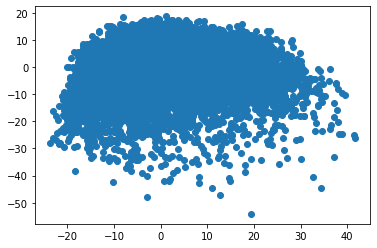

time: 247 ms (started: 2022-08-22 15:01:02 +00:00)


In [21]:
plt.scatter(*x_red.T)
plt.show()

## Draw loading vectors - but how many?

In [22]:
from pyspark.ml.stat import Summarizer

time: 396 µs (started: 2022-08-22 15:01:03 +00:00)


In [23]:
summarizer = Summarizer.metrics("variance")
variance = df.select(summarizer.summary(df.features))
variance.show()

+--------------------------------+
|aggregate_metrics(features, 1.0)|
+--------------------------------+
|            [[0.0051091225963...|
+--------------------------------+

time: 4.02 s (started: 2022-08-22 15:01:03 +00:00)


In [24]:
x = variance.take(1)[0]
variance = x.asDict()['aggregate_metrics(features, 1.0)'].asDict()['variance']
ix = variance.toArray().argsort()
ix = ix[::-1]

time: 4.05 s (started: 2022-08-22 15:01:07 +00:00)


In [25]:
sortedCols = []
for i in ix[:5]:
    sortedCols.append((i, df.columns[i]))

time: 1.27 ms (started: 2022-08-22 15:01:11 +00:00)


In [26]:
sortedCols

[(229, 'colourful'),
 (18, 'absurd'),
 (845, 'reflective'),
 (521, 'horrible'),
 (1019, 'television')]

time: 3.7 ms (started: 2022-08-22 15:01:11 +00:00)


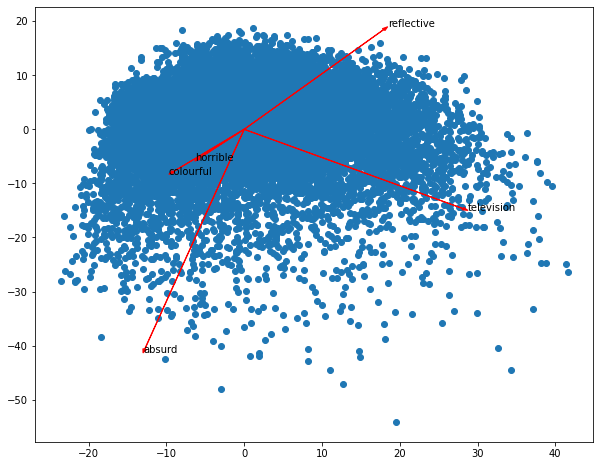

time: 279 ms (started: 2022-08-22 15:01:11 +00:00)


In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(*x_red.T)
pc_matrix = pc.toArray()
for i, tag in sortedCols:
    xx, yy = pc_matrix[i, :] * 500
    ax.arrow(0, 0, xx, yy, color='r', width=0.05, length_includes_head=True, head_width=0.5)
    ax.text(xx, yy, tag)
plt.show()

## Q: How can the same movies be colourful and horrible? 🤔

In [28]:
x = df.select('colourful').rdd
y = df.select('horrible').rdd

time: 149 ms (started: 2022-08-22 15:01:11 +00:00)


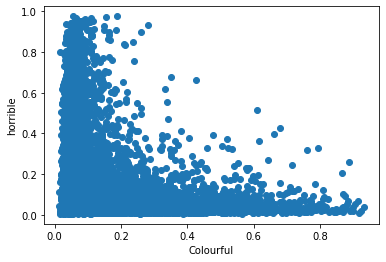

time: 4.87 s (started: 2022-08-22 15:01:11 +00:00)


In [29]:
plt.figure()
plt.scatter(np.array(x.collect()), np.array(y.collect()))
plt.xlabel('Colourful')
plt.ylabel('horrible')
plt.show()

### Finding the explained variance ratio

In [30]:
reduced_rows = matrix_reduced.rows.map(np.array).collect()
reduced_matrix = np.array(reduced_rows)

time: 6.42 s (started: 2022-08-22 15:01:16 +00:00)


In [31]:
reduced_matrix

array([[  5.58054521, -18.61097667],
       [-11.10831191, -13.98894961],
       [ -9.60671636,   1.29851508],
       ...,
       [  3.37264156,  -4.75801367],
       [ 11.39168713, -10.67942055],
       [  1.9800589 ,  -9.38538052]])

time: 3.41 ms (started: 2022-08-22 15:01:22 +00:00)


In [32]:
reduced_matrix.var(axis=0).sum() / (len(df.columns) - 3) * 100

16.08566867393065

time: 4.41 ms (started: 2022-08-22 15:01:22 +00:00)


### Increase the number of components

In [33]:
pc = matrix.computePrincipalComponents(100)
matrix_reduced = matrix.multiply(pc)

time: 22.1 s (started: 2022-08-22 15:01:22 +00:00)


In [34]:
reduced_rows = matrix_reduced.rows.map(np.array).collect()
reduced_matrix = np.array(reduced_rows)
reduced_matrix.var(axis=0).sum() / (len(df.columns) - 3) * 100

67.71827823640295

time: 7.07 s (started: 2022-08-22 15:01:45 +00:00)


In [35]:
pc = matrix.computePrincipalComponents(500)
matrix_reduced = matrix.multiply(pc)

time: 23.6 s (started: 2022-08-22 15:01:52 +00:00)


In [36]:
reduced_rows = matrix_reduced.rows.map(np.array).collect()
reduced_matrix = np.array(reduced_rows)
reduced_matrix.var(axis=0).sum() / (len(df.columns) - 3) * 100

91.08367022946851

time: 9.12 s (started: 2022-08-22 15:02:15 +00:00)
